<h1>Flowers Recognition - Convolucional Neural Network (CNN)</h1>

O propósito deste trabalho é apresentar modelos de Redes Neurais Convolucionais (CNN) utilizados para fazer o reconhecimento de imagens de flores.

Não há um problema específico a ser solucionado, servindo apenas de demonstração do potencial do uso dos recursos computacionais para reconhecimento de imagens, sendo que os modelos apresentados podem ser adaptados para outros contextos e outras bases de dados.

Cada etapa da construção dos modelos será detalhada abaixo e os resultados de <b>acurácia</b> serão apresentados graficamente a cada execução.

Consideramos como dificuldades para realização do trabalho a baixa disponibilidade de imagens rotuladas para as espécies de flores que estamos estudando.

Ainda assim, consideramos a limitação dos recursos computacionais próprios (tendo em vista que fizemos os treinamentos nas máquinas pessoais) para processamento. Ainda que seja um trabalho essencialmente acadêmico, o tempo de execução dos treinamentos e as falhas no processamento por exaustão de recursos (leia-se memória RAM) tornaram o caminho um pouco mais árduo para se conseguir uma conclusão.

<h2>Etapa 1 - Importação de bibliotecas</h2>

Keras é uma API de redes neuras de alto nível para rodar em cima do TensorFlow(Ecossistema open-source para desenvolvimento de aprendizado de máquina - Machine Learning), com foco em permitir a experimentação rápida.

Usamos o bibliotecas de preprocessamento de imagens e de Machine Learning, estas últimas voltadas para as Redes Neurais Convolucionais (CNN)

In [1]:
#Preprocessamento de imagem
from keras.preprocessing.image import ImageDataGenerator

#Bibliotecas para Machine Learning
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adamax,Adadelta
from keras.utils import to_categorical

# Bibliotecas específicas para CNN
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Utilizamos a bibliteoteca scikit-learn para seleção da base de treinamento e teste

In [2]:
#model selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Utilizamos também bibliotecas para manipulação das imagens

In [3]:
import cv2                    
from tqdm import tqdm
import os 
import random as rn 

Adicionalmente fizemos uso das bibliotecas Matplotlib e Seaborn para geração dos gráficos de desempenho dos modelos

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [5]:
%matplotlib inline 
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

<h2>Etapa 2 - Preparação dos dados</h2>

Apontamento da base de dados

In [6]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='flowers/daisy'
FLOWER_SUNFLOWER_DIR='flowers/sunflower'
FLOWER_TULIP_DIR='flowers/tulip'
FLOWER_DANDI_DIR='flowers/dandelion'
FLOWER_ROSE_DIR='flowers/rose'


Construção da base de treinamento e validação

In [7]:
def assign_label(img,flower_type):
    return flower_type

def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

Carregamento das bases com 5 espécies de flores (5 classes)

In [8]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
make_train_data('Tulip',FLOWER_TULIP_DIR)
make_train_data('Dandelion',FLOWER_DANDI_DIR)
make_train_data('Rose',FLOWER_ROSE_DIR)

100%|██████████| 876/876 [00:05<00:00, 170.17it/s]


Visualização randômica de algumas imagens

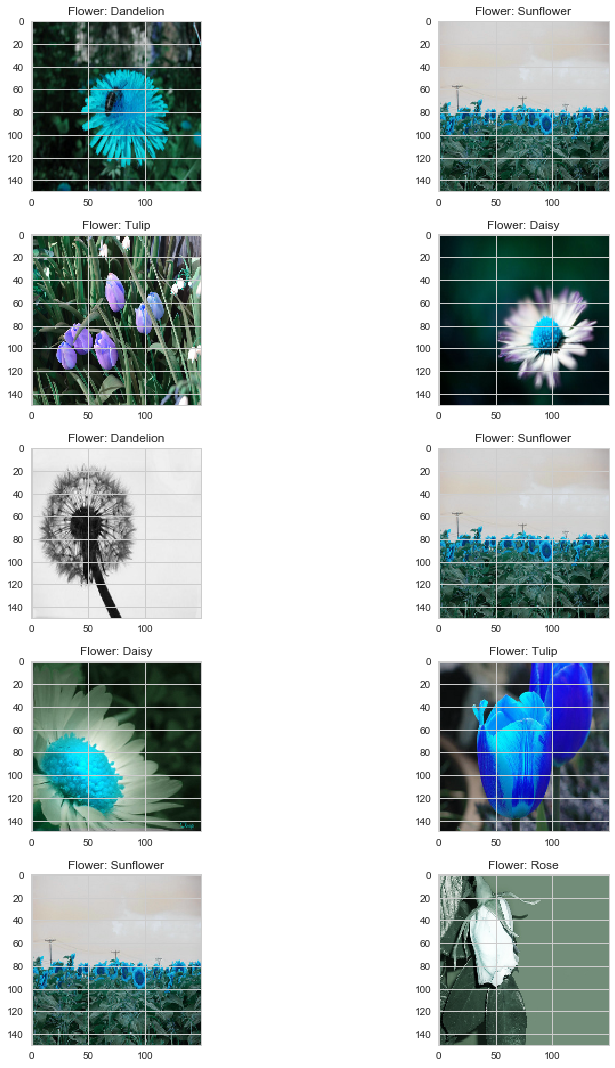

In [9]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

Separação em conjunto de treinamento e validação

In [10]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

Aumento da base de dados com o objetivo de evitar <b>overfitting</b>.

Utilizando a biblioteca de preprocessamento de imagens do Keras, construímos uma função que faz a geração de novas imagens a partir das imagens contidas na base de dados de treinamento, em tempo de execução. Estas novas imagens são geradas aumentando as amostras da base de treinamento por meio de várias transformações aleatórias que geram imagens de aparência confiável em cada execução do modelo, fazendo com que a rede não veja a mesma imagem mais de uma vez.

In [11]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

Definição do tamanho de cada lote de análise e da quantidade de épocas de treinamento

In [12]:
batch_size=128
epochs=5

<h2> Etapa 3 - Definição, compilação, resumo, treinamento e resultado dos modelos</h2>

<h4> Definição do modelo</h4>

Utilizamos o modelo Keras Sequential, que é uma pilha linear de camadas, onde é passada uma lista de camadas para o construtor.

Definimos 4 modelos com pequenas variações de características para fins de comparação.

As camadas foram definidas com a biblioteca Keras Conv2D(convolução espacial sobre imagens). Nas Redes Neurais Convolucionais, as saídas de uma camada são as entradas da próxima camada da lista. Cada camada pode ter diferentes números de filtros e núcleos que são utilizados, de forma resumida, para extrair as características das imagens.

No presente caso, estamos utilizando 4 camadas convolucionais.

Após passar pelas camadas convolucionais, os dados são aplainados (Flatten), ou seja, convertidos em um vetor e entram numa camada densa de 256 classes (Dense) onde são totalmente conectados. A opção pelas 256 classes nestes modelos se deu por não haver melhora significativa dos resultados em que pese ter havido um aumento no consumo de recursos de processamento.

Para um melhor desempenho do modelo é feita a normalização da saída da camada densa (BatchNormalization) e em seguida os dados entram numa nova camada densa com o 5 classes (conforme base de dados rotulada)

Para que o modelo seja compilado é necessário que se passe um otimizador (Optimazer). Cada otimizador tem parâmetros diferentes que melhor se adaptam ao problema a ser solucionado, portanto, a escolha do otimizador vai influenciar nos resultados obtidos pelo modelo.

Para este trabalho optamos pela utilização de 2 otimizados para fins de comparação. Os otimizadores utilizados foram o <b>Adamax</b> e o <b>Adadelta</b>, ambos com seus parâmetros definidos nos valores padrão.

O Adamax é uma variação do otimizador Adam e utiliza a otimização baseada em um gradiente estocástico, que é aquele cujo o estado é indeterminado, com origem em eventos aleatórios.

O Adadelta é uma extensão mais robusta do Adagrad que adapta as taxas de aprendizado com base em uma janela móvel de atualizações do gradiente, em vez de acumular todos os gradientes.

Por fim, ainda para fins de comparação acrescentamos em 2 modelos (um de cada otimizador) a layer Dropout de <b>0.5</b> na entrada da primeira camada densa com o objetivo de previnir o overfitting.

<h3>ADAMAX sem dropout</h3>

In [16]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation = 'softmax'))

model.compile(optimizer=Adamax(lr=0.002),loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              steps_per_epoch=x_train.shape[0] // batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 96)        83040     
__________

<h4>Gráficos para avaliação do desempenho do modelo </h4>

Apresentam a <b>perda</b> (loss) e a <b>acurácia</b> (accuracy) apuradas no treinamento e validação

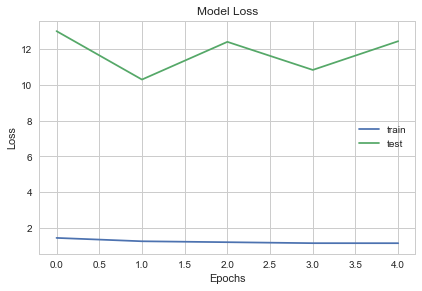

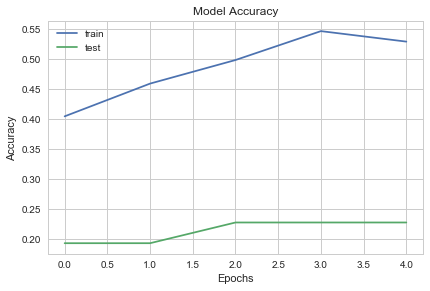

In [17]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

<h3>ADAMAX com dropout</h3>

In [18]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation = 'softmax'))

model.compile(optimizer=Adamax(lr=0.002),loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              steps_per_epoch=x_train.shape[0] // batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 18, 96)        83040     
__________

<h4>Gráficos para avaliação do desempenho do modelo </h4>

Apresentam a <b>perda</b> (loss) e a <b>acurácia</b> (accuracy) apuradas no treinamento e validação

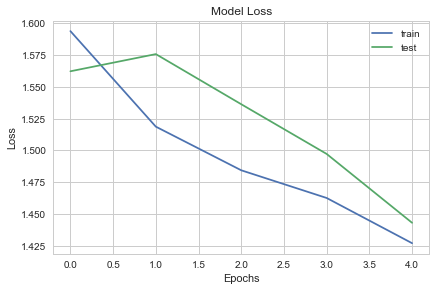

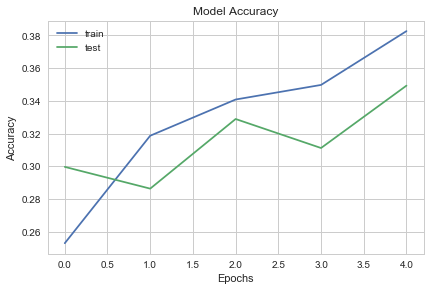

In [19]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

<h3>ADADELTA sem dropout</h3>

In [20]:
#ADADELTA sem dropout
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation = 'softmax'))

model.compile(optimizer=Adadelta(lr=1.0),loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test), 
                              steps_per_epoch=x_train.shape[0] // batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 18, 18, 96)        83040     
__________

<h4>Gráficos para avaliação do desempenho do modelo </h4>

Apresentam a <b>perda</b> (loss) e a <b>acurácia</b> (accuracy) apuradas no treinamento e validação

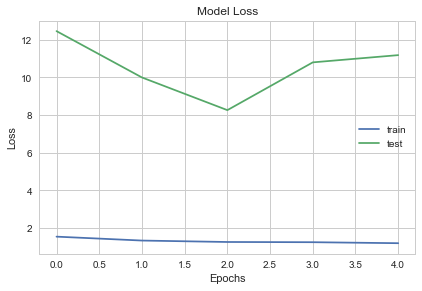

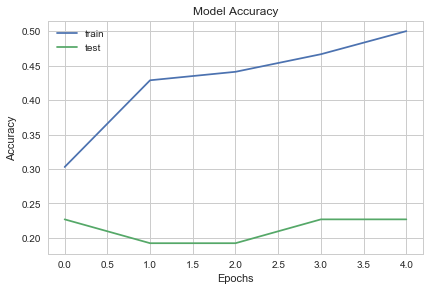

In [21]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

<h3>ADADELTA com dropout</h3>

In [15]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation = 'softmax'))

model.compile(optimizer=Adadelta(lr=1.0),loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              steps_per_epoch=x_train.shape[0] // batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 18, 96)        83040     
__________

<h4>Gráficos para avaliação do desempenho do modelo </h4>

Apresentam a <b>perda</b> (loss) e a <b>acurácia</b> (accuracy) apuradas no treinamento e validação

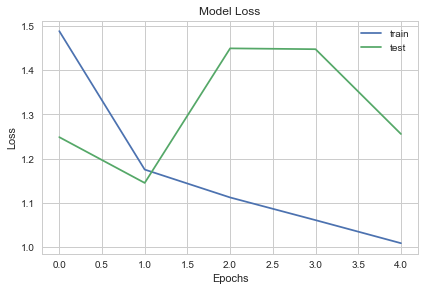

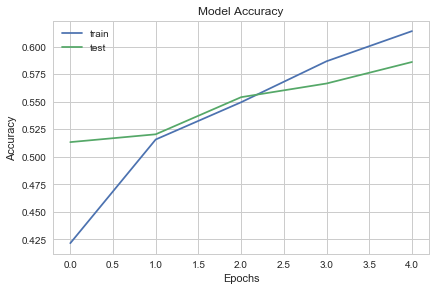

In [16]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

<h1>Conclusão</h1>

Os modelos apresentados demonstram-se satisfatórios nos índices de perda e acurácia no reconhecimento das diversas classes de flores, ainda que seja possível aprimoramentos com novos testes.

Consideramos como possíveis aprimoramentos, a utilização de PCA, a modelagem de SVM's para comparação dos resultados com os modelos de CNN e fazer testes de predição com imagens não vistas nos treinamentos para apurar o quanto os modelos são capazes de identificar as flores apresentadas.